In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn import preprocessing
from sklearn import svm
from sklearn.cross_validation import train_test_split as sk_split
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.ensemble import RandomForestClassifier
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import re
import datetime

# Load datasets
ratings = pd.read_csv('ml-latest/ratings.csv')
print ('Shape of the ratings data frame:', ratings.shape)

tags = pd.read_csv('ml-latest/tags.csv')
print ('Shape of the tags data frame:', tags.shape)

movies = pd.read_csv('ml-latest/movies.csv')
print ('Shape of the movies data frame:', movies.shape)

#Will take
tags = tags.sample(frac=0.2)
ratings = ratings.sample(frac=0.2)

print ('Shape of the sampled ratings data frame:', ratings.shape)
print ('Shape of the sampled tags data frame:', tags.shape)
print ('Shape of the sampled movies data frame:', movies.shape)

('Shape of the ratings data frame:', (26024289, 4))
('Shape of the tags data frame:', (753170, 4))
('Shape of the movies data frame:', (45843, 3))
('Shape of the sampled ratings data frame:', (5204858, 4))
('Shape of the sampled tags data frame:', (150634, 4))
('Shape of the sampled movies data frame:', (45843, 3))


In [34]:
#Print sample ratings data
ratings = ratings.drop(['timestamp'],axis=1)
ratings.head(n=5)

userId  movieId  rating
15110330  157212      589     4.0
13640147  141787     2617     3.0
2847177    29682       10     3.0
19839184  206145     1363     3.0
9521860    98289    72998     5.0

In [35]:
#Display summary statistics about data
ratings.describe()

userId       movieId        rating
count  5.204858e+06  5.204858e+06  5.204858e+06
mean   1.350490e+05  1.584934e+04  3.528822e+00
std    7.817480e+04  3.108090e+04  1.064981e+00
min    1.000000e+00  1.000000e+00  5.000000e-01
25%    6.716700e+04  1.066000e+03  3.000000e+00
50%    1.351960e+05  2.581000e+03  3.500000e+00
75%    2.027270e+05  6.502000e+03  4.000000e+00
max    2.708960e+05  1.762550e+05  5.000000e+00

In [36]:
#Print sample tags data
tags.head(n=5)

userId  movieId              tag   timestamp
196178   76206   107069       friendship  1471380573
498652  179262     3994     twist ending  1446110550
154183   56567    46976     Will Ferrell  1308510533
198130   76206   158872  adult animation  1484424184
699394  253897     1091            goofy  1187431488

In [37]:
#Print sample movies data
movies.head(n=5)

movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy

In [38]:
data = pd.merge(ratings, tags, how='inner')
print ('Shape of the joint data frame:', data.shape)
print (data.head(n=5))

('Shape of the joint data frame:', (26057, 5))
   userId  movieId  rating            tag   timestamp
0   19393   122882     5.0      adventure  1487713584
1   19393   122882     5.0       colorful  1487713645
2   19393   122882     5.0         action  1487713578
3  211166    44191     5.0  inspirational  1444058567
4  106475    71464     4.0         oy vey  1315587768


## 清理数据

In [39]:
for column in data.columns:
    print (column, data[column].nunique())

('userId', 4079)
('movieId', 5493)
('rating', 10)
('tag', 7409)
('timestamp', 25650)


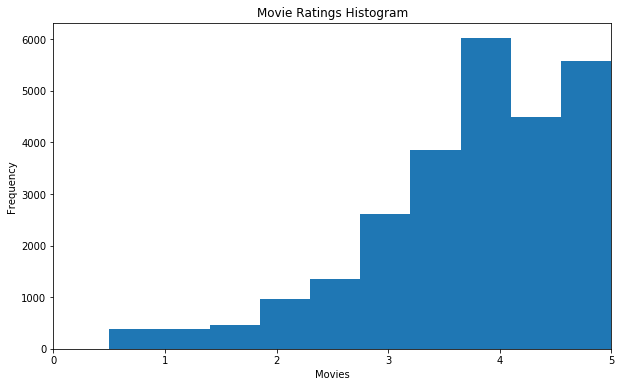

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
plt.hist(data['rating'],10)
plt.xlabel('Movies'); 
plt.ylabel('Frequency')
plt.xlim(0,5)
plt.title('Movie Ratings Histogram')
plt.show()

最频繁的电影评分是4，这也导致了一个不平衡的目标变量，用平均评级来可视化标签


In [41]:
#Remove any special characters from tag
#Relabel ratings 
data['rating'] = data['rating'].apply(lambda x: 1 if x > 4 else 0)

#Delete special characters
data['tag'] = data['tag'].apply(lambda x: str(x))
data['tag'] = data['tag'].map(lambda x: re.sub(r'([^\s\w]|_)+', '', x))
data['tag'] = data['tag'].str.lower()
#Convert timestamp in seconds to datetime format
data['timestamp'] = data['timestamp'].apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
data['timestamp'].astype('datetime64[ns]')[0:5]

0   2017-02-22 05:46:24
1   2017-02-22 05:47:25
2   2017-02-22 05:46:18
3   2015-10-05 23:22:47
4   2011-09-10 01:02:48
Name: timestamp, dtype: datetime64[ns]

In [42]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['tag'])
sequences = tokenizer.texts_to_sequences(data['tag'])

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

pseq = pad_sequences(sequences)
pdseq = pd.DataFrame(pseq)

Found 6625 unique tokens.


In [43]:
vectorizer = CountVectorizer(stop_words='english',decode_error='ignore', analyzer='word')
corpus = data['tag'].values
wordvec = vectorizer.fit_transform(corpus.ravel())
wordvec = wordvec.toarray()

words = vectorizer.get_feature_names()
print("number of words in plot summary: ", len(words))
pdwordvec = pd.DataFrame(wordvec,columns=words)

('number of words in plot summary: ', 6447)


## 降维

## K-Means Clustering Words using Glove Embeddings

- Load Stanford's global word 
- 斯坦福的全球词汇嵌入作为预先训练的模型

In [44]:
embeddings_index = {}
f = open('glove.6B/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

embedding_matrix = np.zeros((len(words), 100))
for i in range(len(words)):
    embedding_vector = embeddings_index.get(words[i])
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        
pdembedding = pd.DataFrame(embedding_matrix.T,columns=words)

Found 400000 word vectors.


In [45]:
pdembedding[0:5]

007  050206  070406        10       100        11      13th        15  \
0  1.01850     0.0     0.0  0.086759  0.281330  0.347730  0.028287  0.157570   
1 -0.41461     0.0     0.0  0.343100  0.752390  0.173930 -0.341900  0.075029   
2  1.25320     0.0     0.0  0.015262 -0.055879  0.032938  0.851190 -0.120950   
3 -0.03777     0.0     0.0 -0.211760  0.165300 -0.272590  0.409790 -0.096086   
4 -0.20713     0.0     0.0  0.016745  0.312520  0.313020  0.400590  0.243910   

       17th    1800s       ...             zoe   zombie  zombies    zooey  \
0  0.074392  0.36931       ...        0.875850 -0.33894 -0.15087  0.70692   
1 -0.272340  0.34400       ...       -0.067071  0.29189  0.20890  0.63465   
2  0.646130 -0.15759       ...       -0.323010  0.29925  0.75442 -0.45704   
3  0.640480  0.51441       ...       -0.640720 -0.65192 -0.81336 -0.77984   
4  0.417400 -0.37421       ...       -0.161300 -0.45548 -0.20850 -0.62618   

   zoomm  zovatto   zulueta     zwick  zwigoff  zzzzzzzzzzzzzz  
0    0.0      0.0 -0.006858  0.251150  0.37750             0.0  
1    0.0      0.0 -0.674700  0.649930  0.10591             0.0  
2    0.0      0.0 -0.545450 -0.246510 -0.71806             0.0  
3    0.0      0.0  0.322860 -1.113800 -0.41457             0.0  
4    0.0      0.0 -0.284740 -0.049978 -0.28597             0.0  

[5 rows x 6447 columns]

In [46]:
reduced_data = PCA(n_components=2,svd_solver='auto').fit_transform(pdembedding.T)
kmeans = KMeans(init='k-means++', n_clusters=100, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)


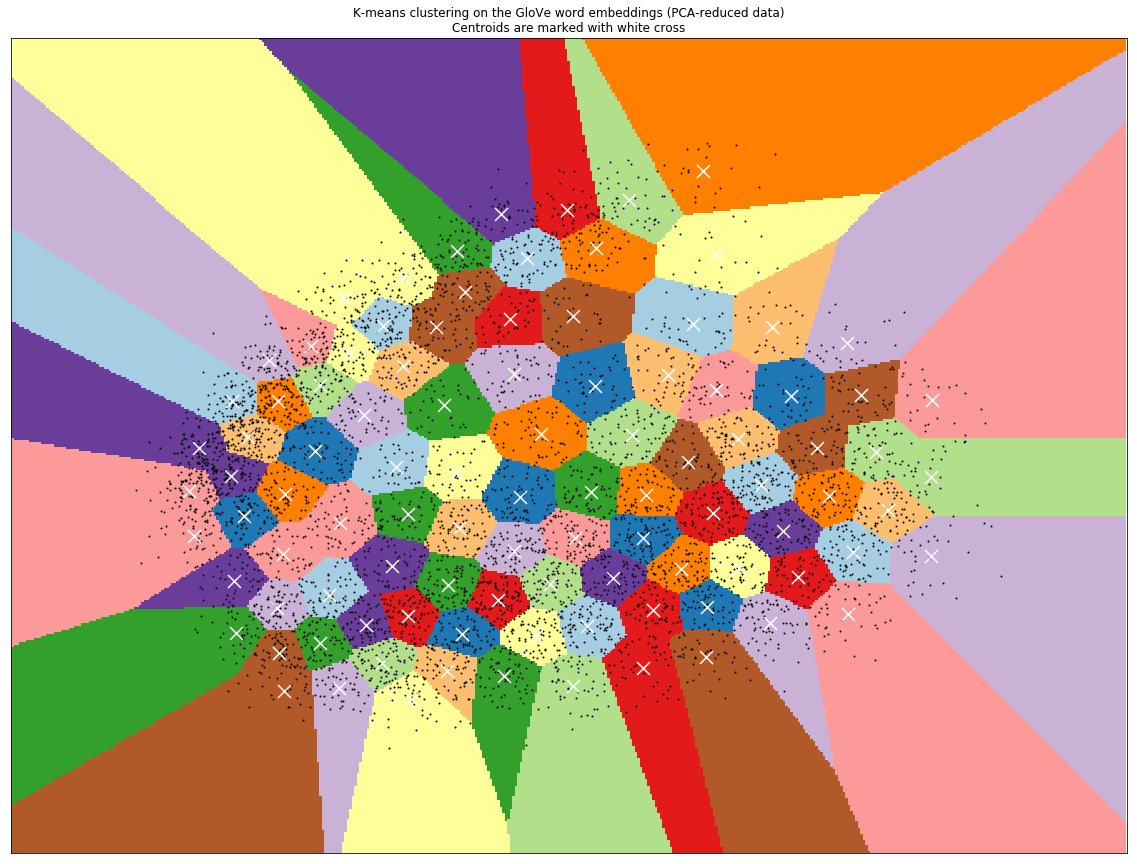

In [47]:
plt.figure(figsize=(20, 15))
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', label=words,markersize=2)
        
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the GloVe word embeddings (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

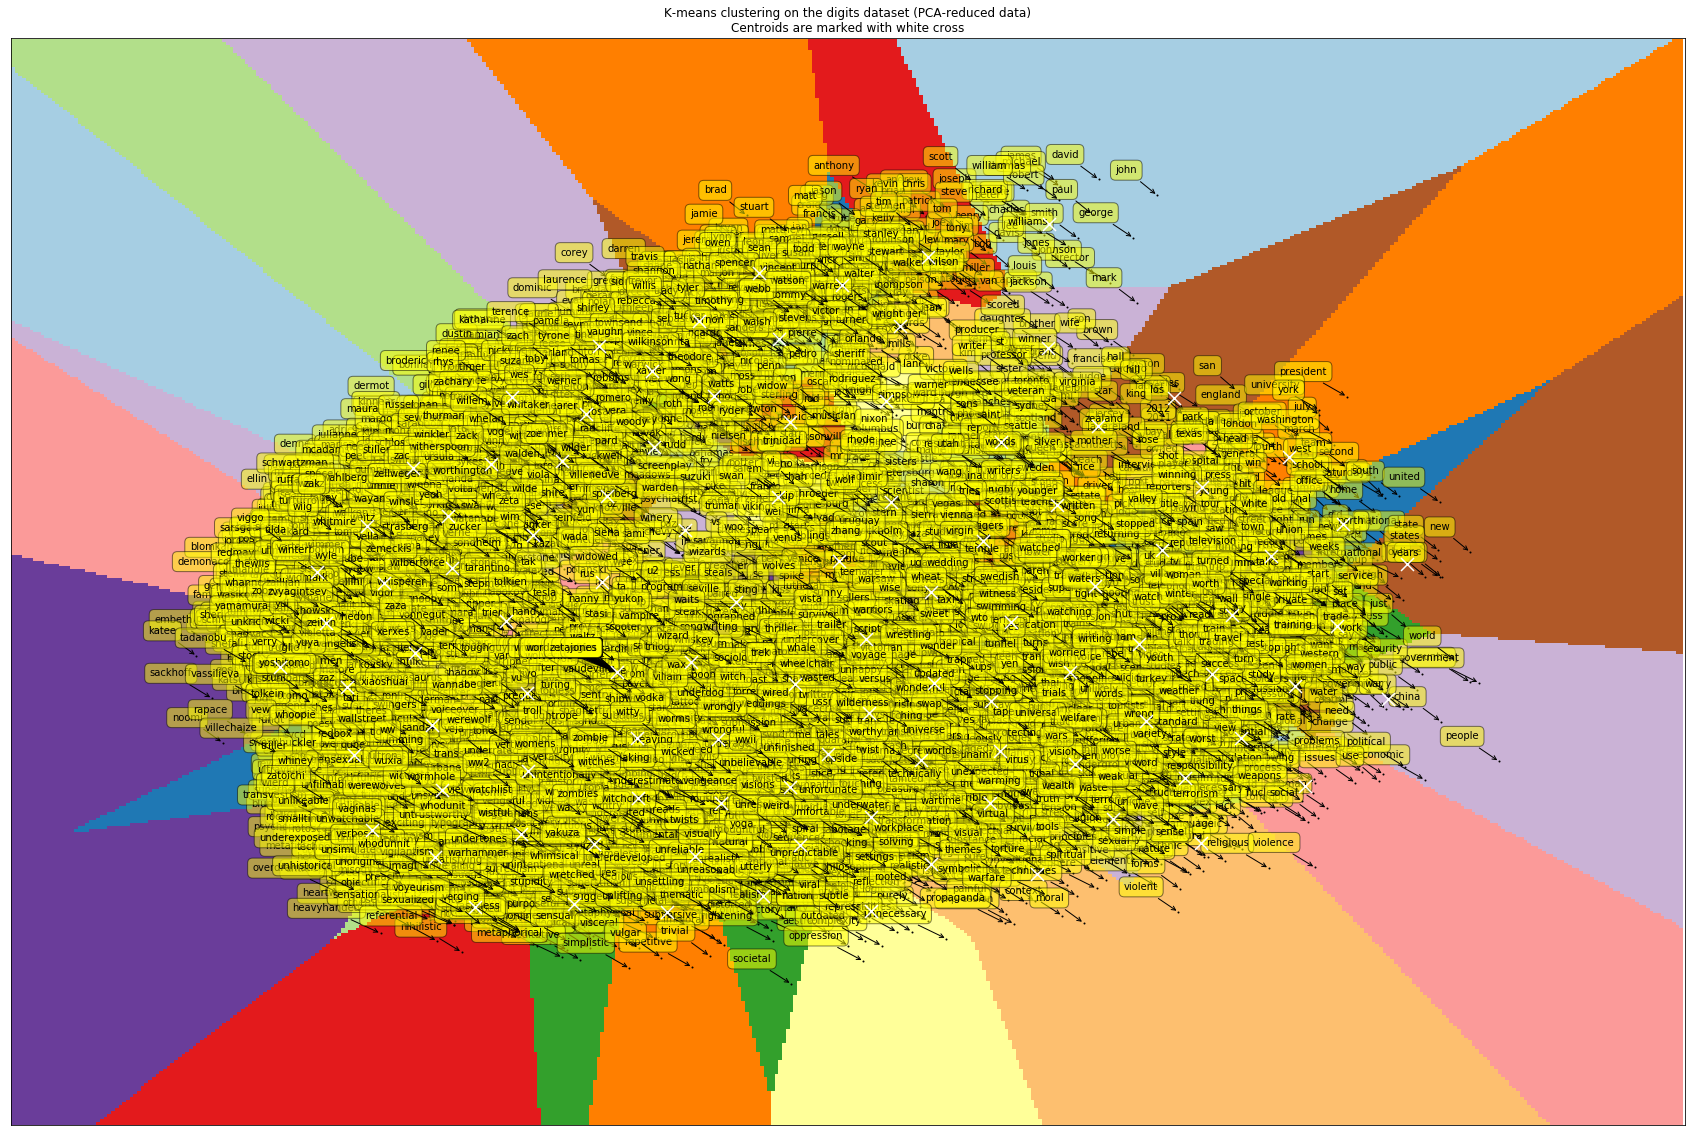

In [160]:
plt.figure(figsize=(30, 20))
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', label=words,markersize=2)
for label, x, y in zip(words, reduced_data[:, 0], reduced_data[:, 1]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-20, 20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
        
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

### Prepare data for Deep Learning

In [11]:
# For deep learning with LSTM, we will only use word sequences
dpdata = pd.concat([data, pdseq], axis=1)

dpdata = dpdata.drop(['tag'], axis=1)
dpdata = dpdata.drop(['userId'], axis=1)
dpdata = dpdata.drop(['movieId'], axis=1)


### Prepare data for Clustering

In [48]:
#Cluster word embeddings data 
kmeans = KMeans(init='k-means++', n_clusters=300, n_init=10)
kmeans.fit(pdembedding.T)
#Get cluster labels
clusters = kmeans.labels_

#Add columns to data for each cluster
for i in range(max(clusters)+1):
 data[i] = 0

#If word is in data row, label the associated cluster accordingly with 1
for i in range(len(pdwordvec.columns)):
    column = pdwordvec.columns[i]
    index = pdwordvec[column].loc[pdwordvec[column] > 0, ].index
    for ii in range(len(index)):
        data.loc[index[ii],clusters[i]] = 1

In [49]:
#Drop tag as we will use vectorized words
data = data.drop(['tag'], axis=1)

#Add genres
#Split genre column
genresplit = movies.set_index('movieId').genres.str.split(r'|', expand=True).stack().reset_index(level=1, drop=True).to_frame('genre')
#Use one-hot encoding grouped by genre 
genres = pd.get_dummies(genresplit, prefix='genre', columns=['genre']).groupby(level=0).sum()
#Drop unnecessary field, if all genres are 0 then it means no genres are listed. 
genres = genres.drop(['genre_(no genres listed)'], axis=1)
#Joın data by movieId
genres['movieId'] = genres.index
data = pd.merge(data, genres, on='movieId', how='left')

#Assign variables as categorical using one hot encoding
useridencoding = pd.get_dummies(data['userId'], prefix='userid')
data = data.drop(['userId'], axis=1)
data = pd.concat([data, useridencoding], axis=1)

movieidencoding = pd.get_dummies(data['movieId'], prefix='movieid')
data = data.drop(['movieId'], axis=1)
data = pd.concat([data, movieidencoding], axis=1)

In [50]:
data = data.fillna(np.nan)

# Machine Learning Classification Models

选择了精确度作为关键指标

将在2016-2016年之前使用这些数据作为训练集，并使用剩下的12个月的数据作为测试集。

In [51]:
#Convert timestamp in seconds to datetime format
train = data[(data['timestamp'] < '2016-08-01') ]
test = data[(data['timestamp'] >= '2016-08-01') ]

print "Number of rows in test data set:", (len(test))
print "Number of rows in training data set:",(len(train))

Number of rows in test data set: 4125
Number of rows in training data set: 21932


12 months of data with 4k cases will definitely provide a good model accuracy measure. 

In [52]:
#remove timestamp as it won't be needed for modeling
train = train.drop(['timestamp'], axis=1)
test = test.drop(['timestamp'], axis=1)

In [53]:
#Define target and predictor variables
y_train = train['rating']
y_test = test['rating']
x_train = train.drop(['rating'], axis=1)
x_test = test.drop(['rating'], axis=1)

In [54]:
#基准准确率线
baselineaccuracy = float(y_test.value_counts().max())/y_test.value_counts().sum()
print "Accuracy of the baseline model is: ", np.round(baselineaccuracy,2)

Accuracy of the baseline model is:  0.57


## Logistic Regression Model

In [55]:
logreg = LogReg(C = 1, class_weight='balanced')
logreg.fit(x_train, y_train)
y_predlog = logreg.predict_proba(x_test)
R2_log = logreg.score(x_test,y_test) 
print "Accuracy of the test set for log. reg. is: ", np.round(R2_log,2)

Accuracy of the test set for log. reg. is:  0.65


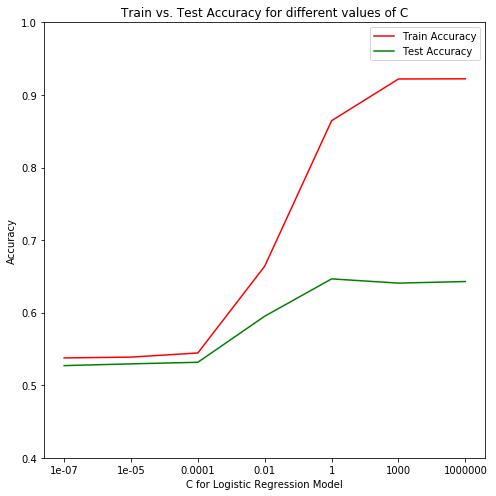

('Accuracy is maximum at C value of', 1, 'and yields accuracy of', 0.65)


In [57]:
depth = [0.0000001,0.00001,0.0001,0.01, 1, 1000, 1000000]

train_acc = []
test_acc = []

for i in depth:
    logit = LogReg( C = i, class_weight='balanced')
    logit.fit(x_train, y_train)
    train_acc.append(logit.score(x_train, y_train))
    test_acc.append(logit.score(x_test, y_test))

#Visualize accuracy for different regularization parameters
plt.figure(figsize=(7,7))
plt.plot(train_acc, color='r', label='Train Accuracy')
plt.plot(test_acc, color='g', label='Test Accuracy')
plt.xticks(range(7), depth)
plt.xlabel('depth for Logistic Regression Model')
plt.ylabel('Accuracy')
plt.ylim(0.4,1)
plt.title('Train vs. Test Accuracy for different values of C')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

print('Accuracy is maximum at depth value of', depth[np.argmax(test_acc)],'and yields accuracy of', round(max(test_acc), 2))


## Random Forest

In [60]:
RFC = RandomForestClassifier(class_weight='balanced')
RFC.set_params(n_estimators=100)
RFC.fit(x_train,y_train)
R2_rfc = RFC.score(x_test,y_test) 
print "Accuracy of the test set for random forest is: ", np.round(R2_rfc,2)

Accuracy of the test set for random forest is:  0.65


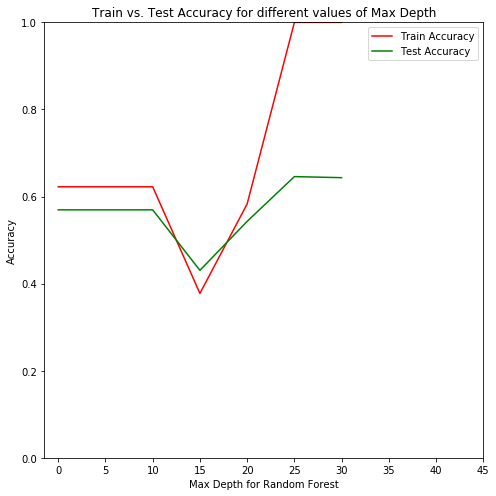

('Accuracy is maximum at max depth value of', 25, 'and yields accuracy of', 0.65)


In [94]:
depth = range(0,50,5)
train_acc = []
test_acc = []

for i in c:
    RFC.set_params(n_estimators=100, max_depth=i)
    RFC.fit(x_train, y_train)
    train_acc.append(RFC.score(x_train, y_train))
    test_acc.append(RFC.score(x_test, y_test))


#Visualize accuracy for different regularization parameters
plt.figure(figsize=(7,7))
plt.plot(train_acc, color='r', label='Train Accuracy')
plt.plot(test_acc, color='g', label='Test Accuracy')
plt.xticks(range(9), depth)
plt.xlabel('Max Depth for Random Forest')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.title('Train vs. Test Accuracy for different values of Max Depth')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

print('Accuracy is maximum at max depth value of', depth[np.argmax(test_acc)],
                'and yields accuracy of', round(max(test_acc), 2))

In [95]:
importance = RFC.feature_importances_
importance = pd.DataFrame(importance, index=x_train.columns, 
                          columns=["Importance"])
importance["Std"] = np.std([tree.feature_importances_
                            for tree in RFC.estimators_], axis=0)

importance['Importance'].sort_values(ascending=False)[1:10]

genre_Drama        0.008004
genre_Thriller     0.007068
userid_78340       0.006642
genre_Comedy       0.006539
userid_76206       0.006234
genre_Romance      0.006174
genre_Sci-Fi       0.005989
userid_257255      0.005941
genre_Adventure    0.005865
Name: Importance, dtype: float64

In [215]:
importance[importance['Importance']==0].count()

Importance    2913
Std           2913
dtype: int64

In [222]:
clus = np.where(clusters==12)
clus = np.array(clus)
clus = pd.DataFrame(clus)
clussamp = clus.T.sample(10,replace=True)

clus = []
for index, row in clussamp.iterrows():
    clus.append(int(row.values))

for i in clus:
    print words[i]

scientology
religion
judaism
islam
christianity
scientology
scientology
christianity
scientology
judaism
judaism
catholicism
islam
christianity
scientology
religion
catholicism
islam
catholicism
scientology


In [22]:
from sklearn.naive_bayes import MultinomialNB
NB = MultinomialNB()
NB.fit(x_train,y_train)
R2_nb = NB.score(x_test,y_test) 
print "Accuracy of the test set for Multinomial NB model is: ", np.round(R2_nb,2)

Accuracy of the test set for Multinomial NB model is:  0.68


In [225]:
from sklearn.ensemble import AdaBoostClassifier

AdaB = AdaBoostClassifier()
AdaB.fit(x_train,y_train)
R2_ada = AdaB.score(x_test,y_test) 
print "Accuracy of the test set for AdaBoost model is: ", np.round(R2_ada,2)

Accuracy of the test set for AdaBoost model is:  0.6


In [23]:
import xgboost as xgb

clf = xgb.XGBClassifier(max_depth=20, learning_rate=0.1) 
                
            
clf.fit(x_train, y_train, early_stopping_rounds=10, eval_set=[(x_train, y_train), (x_test, y_test)])  
R2_xgb = clf.score(x_test,y_test) 
print "Accuracy of the test set for XGBoost model is: ", np.round(R2_xgb,2)

[0]	validation_0-error:0.341858	validation_1-error:0.399372
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.331522	validation_1-error:0.396473
[2]	validation_0-error:0.333036	validation_1-error:0.399613
[3]	validation_0-error:0.336333	validation_1-error:0.397439
[4]	validation_0-error:0.332413	validation_1-error:0.395265
[5]	validation_0-error:0.332769	validation_1-error:0.400338
[6]	validation_0-error:0.328403	validation_1-error:0.397439
[7]	validation_0-error:0.327913	validation_1-error:0.396956
[8]	validation_0-error:0.32573	validation_1-error:0.396956
[9]	validation_0-error:0.327289	validation_1-error:0.397439
[10]	validation_0-error:0.328002	validation_1-error:0.398647
[11]	validation_0-error:0.325774	validation_1-error:0.391399
[12]	validation_0-error:0.323368	validation_1-error:0.390191
[13]	validation_0-error:0.322789	validation_1-error:0.390

## Ensemble Model of Deep Learning and Logistic Regression 

In [1]:
#Calculate weighted probabilities 
y_pred = (0.4*y_predlstm + 0.6*y_predlog)

#Predict ratings using the weighted probabilities
y_predensem = np.zeros((len(y_pred)))
for i in range(len(y_pred)):
    if y_pred[i,1] >= 0.5:
        y_predensem[i] = 1

from sklearn.metrics import accuracy_score
print "Accuracy of the test set for Ensemble model is: ", np.round(accuracy_score(y_test, y_predensem),2)   

Accuracy of the test set for Ensemble model is: 0.67
